<a href="https://colab.research.google.com/github/Gaoshu-root/Code-related-courses/blob/main/%E7%AC%94%E8%AE%B0_%E6%89%93%E5%8D%A1/%E3%80%8A%E5%A4%A7%E8%AF%AD%E8%A8%80%E6%A8%A1%E5%9E%8B%E3%80%8B_%E4%BA%BA%E5%A4%A7/Transformer%20%E4%BB%A3%E7%A0%81%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

整理自链接：
* https://github.com/harvardnlp/annotated-transformer
   * 版本 2023：http://nlp.seas.harvard.edu/annotated-transformer/
   * 版本 2018： https://nlp.seas.harvard.edu/2018/04/03/attention.html

* 官方代码库：https://github.com/tensorflow/tensor2tensor

[论文笔记链接](https://blog.csdn.net/weixin_46034116/article/details/146240047?spm=1011.2415.3001.5331)



# —— 代码运行需要导入的模块

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax
from torch.autograd import Variable
import copy, math

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 3 模型架构

## 3.1 编码器 和 解码器 堆叠

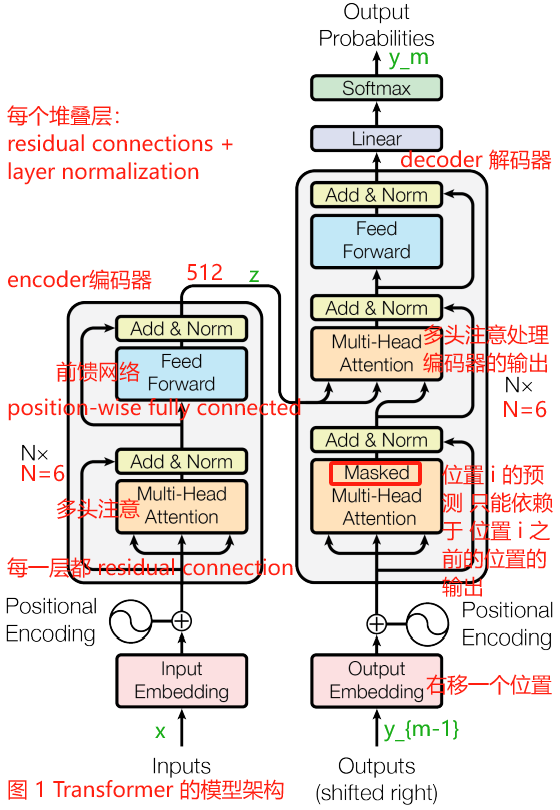

In [ ]:
class EncoderDecoder(nn.Module):
  """
  标准 Encoder-Decoder 架构
  """

  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super().__init__()
    self.encoder = encoder  # 编码器
    self.decoder = decoder  # 解码器
    self.src_embed = src_embed  # 输入的 embedding
    self.tgt_embed = tgt_embed  # 目标 embedding
    self.generator = generator  # 生成器

  def forward(self, src, tgt, src_mask, tgt_mask):
    "输入并处理 掩码的 源序列 和 目标序列 "
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

# Transormer 的 解码器输出前的 Linear + Softmax 部分
class Generator(nn.Module):
  "Define standard linear + softmax generation step."

  def __init__(self, d_model, vocab):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return log_softmax(self.proj(x), dim=-1)

### 编码器

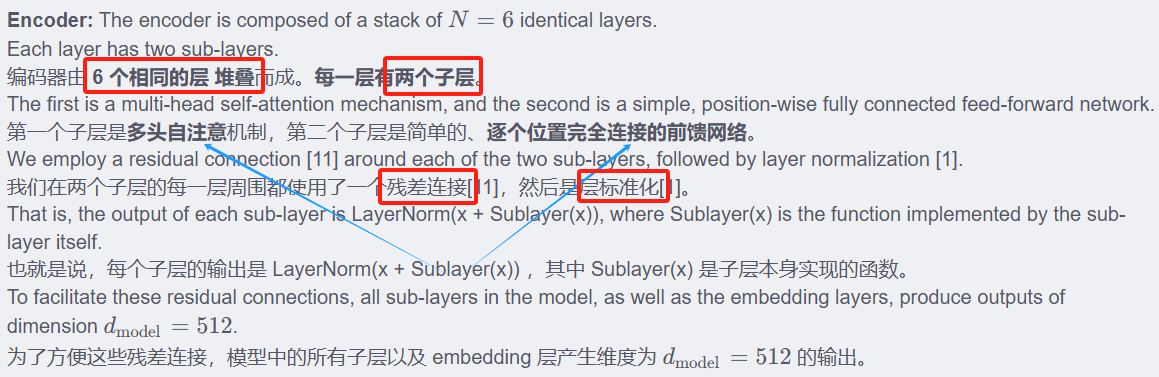

In [ ]:
def clones(module, N): # 论文令 N = 6
  "产生 N 个相同的层 "
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])




# Transormer 架构的 编码器核心是 6 层堆叠
class Encoder(nn.Module):
  "Core encoder is a stack of N layers"

  def __init__(self, layer, N):
    super().__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    " 让 input (and mask) 依次通过这些层"
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

#### ——  层标准化 处理模块

In [ ]:
class LayerNorm(nn.Module):
  "创建 层标准化 模块"

  def __init__(self, features, eps=1e-6):
    super().__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

#### ——  层间残差连接 处理模块

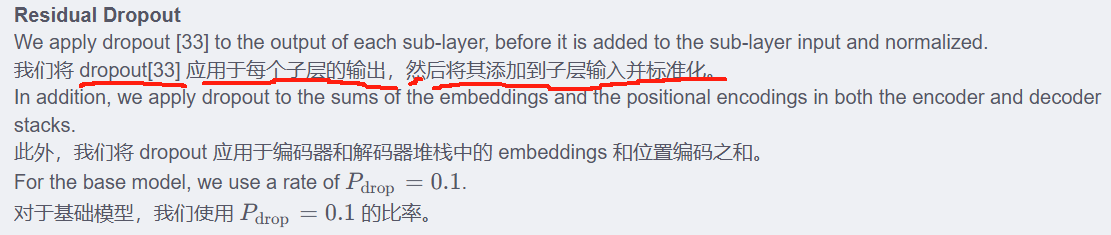

In [ ]:
class SublayerConnection(nn.Module):
  """
  残差连接residual connection +  层标准化layer norm.
  Note for code simplicity the norm is first as opposed to last.
  """

  def __init__(self, size, dropout):
    super().__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    "Apply residual connection to any sublayer with the same size."
    return x + self.dropout(sublayer(self.norm(x)))

#### 图 1 左： 编码器部分

In [ ]:
# 第一个子层是多头自注意机制，第二个子层是简单的、逐个位置完全连接的前馈网络。

class EncoderLayer(nn.Module):
  "Encoder is made up of self-attn and feed forward (defined below)"

  def __init__(self, size, self_attn, feed_forward, dropout):
    super().__init__()
    self.self_attn = self_attn  # multi-head self-attention
    self.feed_forward = feed_forward  # 前馈网络 position-wise fully connected feed-forward network.
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    "遵循 图 1 左侧 进行连接 "
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # 第一个子层 多头自注意
    return self.sublayer[1](x, self.feed_forward) # 第二个子层 逐个位置完全连接的前馈网络

### 解码器

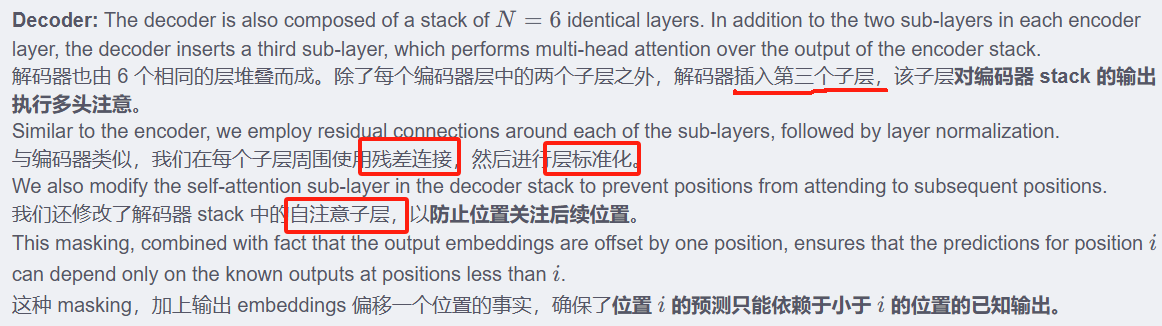

In [ ]:
class Decoder(nn.Module):
  "Generic N layer decoder with masking."

  def __init__(self, layer, N):
    super().__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

#### 图 1 右： 解码器部分

In [ ]:
# 解码器 的 3 个子层：
# 3、前馈网络
# 2、多头注意    输入：解码器的输出，上一层的输出
# 1、对编码器 stack 的输出执行多头注意
class DecoderLayer(nn.Module):
  "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super().__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3) # 3 个子层

  def forward(self, x, memory, src_mask, tgt_mask):
    "遵循 图 1 右进行连接"
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

#### —— mask 模块  

In [ ]:
def subsequent_mask(size):
  "Mask out subsequent positions."
  attn_shape = (1, size, size)
  subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
      torch.uint8
  )
  return subsequent_mask == 0

##### example_mask 可视化

注意掩码显示了每个目标单词（行）被允许查看的位置（列）。

在训练过程中，单词会被阻止关注将来的单词。

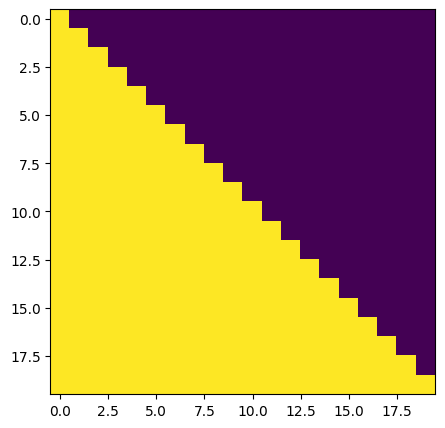

In [ ]:
# 无特殊含义，就是 第 i 个单词只能注意 i 之前的单词
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [ ]:
# print(a001)  # 自设置的 Notebook 运行中断

## 3.2 Attention

输出 = attention(查询,$~~$键,$~~$值)



### 3.2.1 Scaled Dot-Product Attention

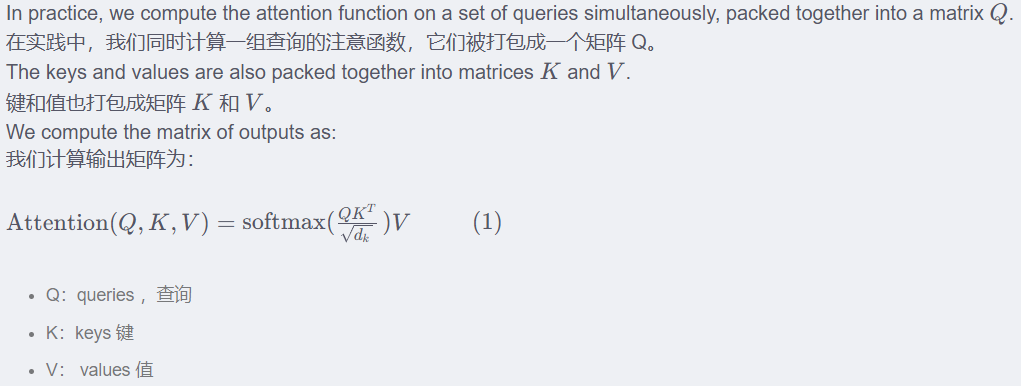

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
  "Compute 'Scaled Dot Product Attention'"
  d_k = query.size(-1) # .size(-1) 返回的是该张量最后一个维度的大小
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # 式(1) 括号里
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = scores.softmax(dim=-1)  # softmax
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn  # 乘以 V

### 3.2.2 Multi-Head Attention

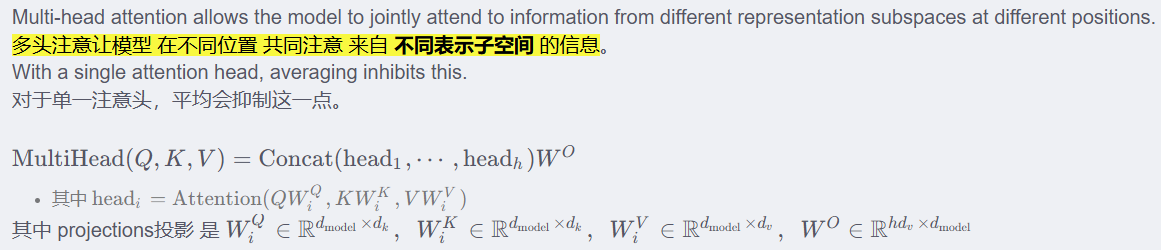

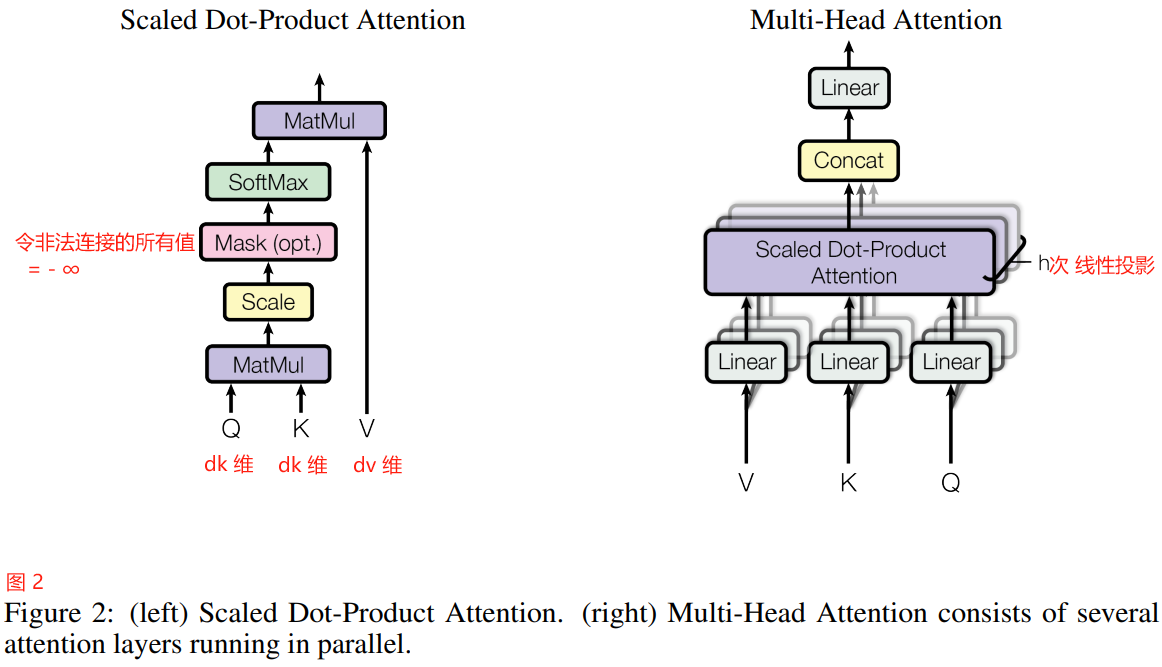

In [ ]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    "Take in model size and number of heads. 模型大小， 注意头的数量"
    super().__init__()
    assert d_model % h == 0
    # We assume d_v always equals d_k
    self.d_k = d_model // h
    self.h = h  # 线性投影次数 h 和 注意 heads 数目一样
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    "实现 图 2"
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)
    nbatches = query.size(0)

    # 1) Do all the linear projections in batch from d_model => h x d_k  图 2 右图 底下的线性投影
    query, key, value = [
      lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
      for lin, x in zip(self.linears, (query, key, value))
    ]

    # 2) Apply attention on all the projected vectors in batch. 图 2 右图 中间的 Scaled Dot-Product Attention
    x, self.attn = attention(
      query, key, value, mask=mask, dropout=self.dropout
    )

    # 3) "Concat" using a view and apply a final linear. 图 2 右图 的上面 2 步： Concat —> Linear
    x = (
      x.transpose(1, 2)
      .contiguous()
      .view(nbatches, -1, self.h * self.d_k)
    )
    del query
    del key
    del value
    return self.linears[-1](x)

## 3.3 Position-wise 前馈网络

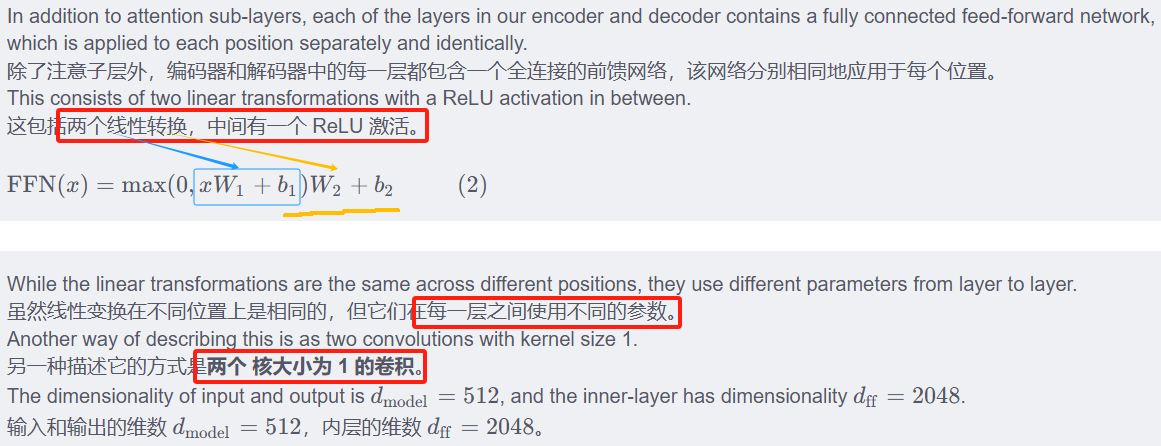

In [ ]:
class PositionwiseFeedForward(nn.Module):
  "Implements FFN equation."

  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    self.w_1 = nn.Linear(d_model, d_ff) # 第 1 个 线性变换 层
    self.w_2 = nn.Linear(d_ff, d_model) # 第 2 个 线性变换 层
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

## 3.4 Embeddings 和 Softmax

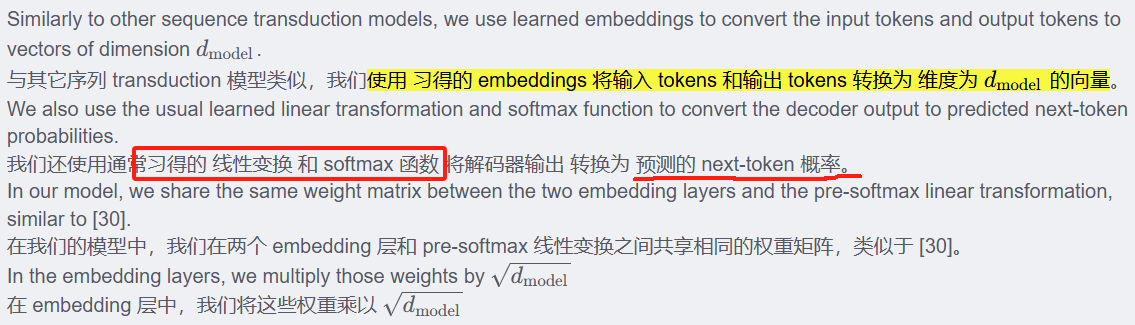

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super().__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model

  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

## 3.5 Positional Encoding 位置编码

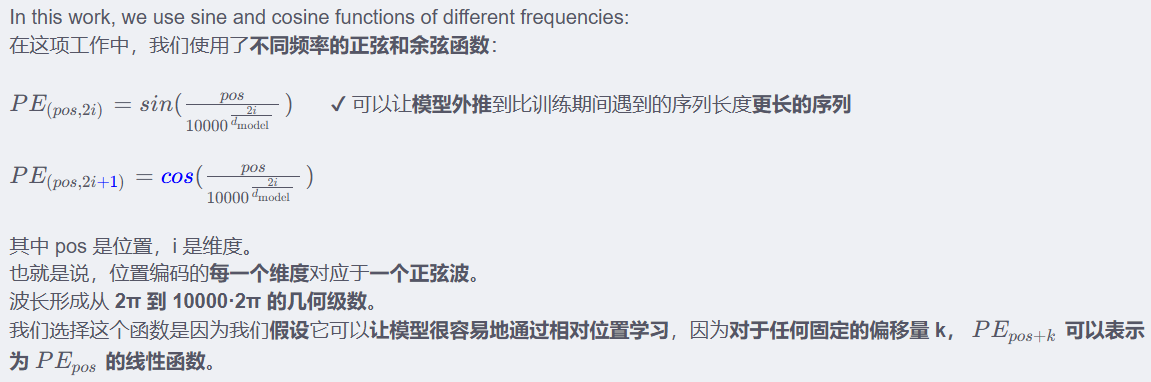

由  $a^b=\exp(b·\ln(a))$ 和 $\ln(a^b)=b·\ln(a)$

$\frac{1}{10000^{\frac{2i}{d_\text{model}}}}=\exp\Big (\ln (\frac{1}{10000^{\frac{2i}{d_\text{model}}}})\Big)$

$\ln (\frac{1}{10000^{\frac{2i}{d_\text{model}}}})=\ln1-\ln (10000^{\frac{2i}{d_\text{model}}})=-\frac{2i}{d_\text{model}}·\ln(10000)$

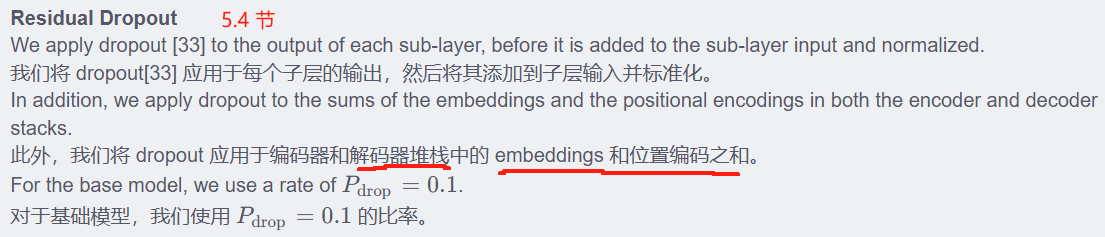

In [ ]:
class PositionalEncoding(nn.Module):
  "Implement the PE function. 实现 Positional Encoding 位置编码 模块"

  def __init__(self, d_model, dropout, max_len=5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin(position * div_term) #
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe)

  def forward(self, x):
    x = x + self.pe[:, : x.size(1)].requires_grad_(False)
    return self.dropout(x)

### example_position：可视化 position 【x 轴】  和 embedding 【y 轴】

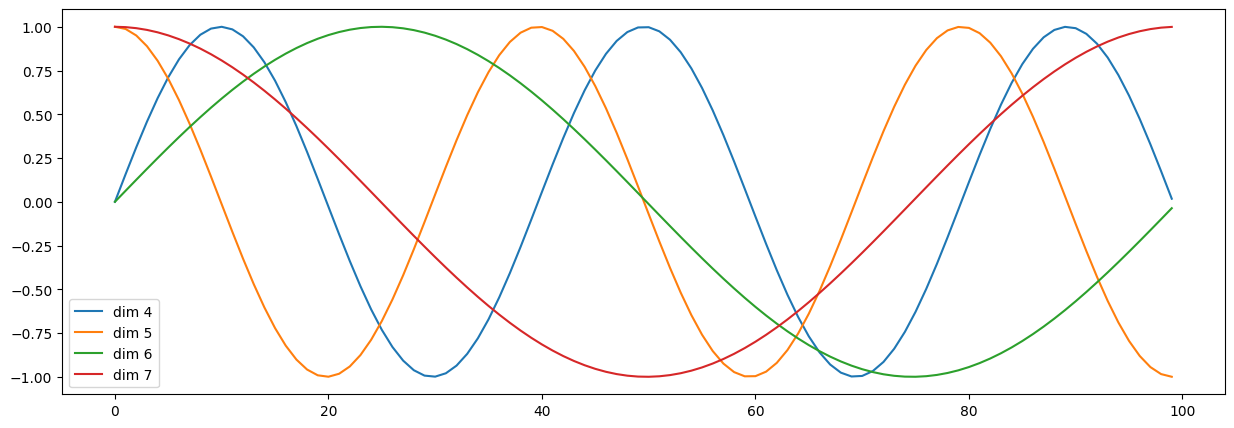

In [ ]:
"""
下面的位置编码将根据位置添加正弦波。
波的频率和偏移量在每个维度上都是不同的。
"""

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [ ]:
# print(a000)

# 从参数到完整模型

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
  "Helper: Construct a model from hyperparameters."
  c = copy.deepcopy
  attn = MultiHeadedAttention(h, d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab),
  )

  # This was important from their code.
  # Initialize parameters with Glorot / fan_avg.
  for p in model.parameters():
      if p.dim() > 1:
          nn.init.xavier_uniform_(p)
  return model

# 推理

目标：生成模型的预测。

我们试着用 Transformer 来记忆输入。由于模型尚未训练，因此**输出是随机生成的。**

In [ ]:
def inference_test():
  test_model = make_model(11, 11, 2)
  test_model.eval()
  src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
  src_mask = torch.ones(1, 1, 10)

  memory = test_model.encode(src, src_mask)
  ys = torch.zeros(1, 1).type_as(src)

  for i in range(9):
    out = test_model.decode(
        memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
    )
    prob = test_model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat(
        [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
    )

  print("未经训练的模型 的预测 示例:", ys)


def run_tests():
  for _ in range(10):
      inference_test()


def run_tests():
  for _ in range(10):
      inference_test()

run_tests()

未经训练的模型 的预测 示例: tensor([[ 0,  8,  1,  2,  4,  3, 10,  4,  3,  5]])
未经训练的模型 的预测 示例: tensor([[0, 1, 3, 3, 3, 3, 3, 3, 3, 3]])
未经训练的模型 的预测 示例: tensor([[ 0,  4,  5,  5,  5,  5,  5,  5, 10,  8]])
未经训练的模型 的预测 示例: tensor([[0, 7, 1, 2, 2, 2, 2, 2, 2, 2]])
未经训练的模型 的预测 示例: tensor([[0, 6, 5, 5, 5, 5, 5, 5, 5, 5]])
未经训练的模型 的预测 示例: tensor([[ 0, 10,  3,  6,  4,  9,  9,  9,  3,  6]])
未经训练的模型 的预测 示例: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
未经训练的模型 的预测 示例: tensor([[ 0, 10, 10, 10, 10,  6,  1,  8,  9,  9]])
未经训练的模型 的预测 示例: tensor([[0, 9, 5, 8, 7, 4, 7, 4, 6, 1]])
未经训练的模型 的预测 示例: tensor([[0, 5, 2, 5, 5, 5, 5, 5, 5, 5]])


# 5 模型训练

介绍一些训练标准编码器和解码器模型所需的工具。

首先，我们定义一个**批处理**对象，其中包含用于训练的 src 和目标句子，以及构造掩码。

## —— Batches and Masking

In [ ]:
class Batch:
  """Object for holding a batch of data with mask during training."""

  def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
    self.src = src
    self.src_mask = (src != pad).unsqueeze(-2)
    if tgt is not None:
      self.tgt = tgt[:, :-1]
      self.tgt_y = tgt[:, 1:]
      self.tgt_mask = self.make_std_mask(self.tgt, pad)
      self.ntokens = (self.tgt_y != pad).data.sum()

  @staticmethod
  def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
      tgt_mask.data
    )
    return tgt_mask

接下来，我们创建一个通用的**训练和评分函数**来跟踪损失。

我们传入一个泛型损失计算函数，该函数也处理参数更新。

## —— Training Loop

In [ ]:
class TrainState:
  """Track number of steps, examples, and tokens processed"""

  step: int = 0  # Steps in the current epoch
  accum_step: int = 0  # Number of gradient accumulation steps
  samples: int = 0  # total # of examples used
  tokens: int = 0  # total # of tokens processed

In [ ]:
def run_epoch(
  data_iter,
  model,
  loss_compute,
  optimizer,
  scheduler,
  mode="train",
  accum_iter=1,
  train_state=TrainState(),
):
  """Train a single epoch"""
  start = time.time()
  total_tokens = 0
  total_loss = 0
  tokens = 0
  n_accum = 0
  for i, batch in enumerate(data_iter):
    out = model.forward(
      batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
    )
    loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
    # loss_node = loss_node / accum_iter
    if mode == "train" or mode == "train+log":
      loss_node.backward()
      train_state.step += 1
      train_state.samples += batch.src.shape[0]
      train_state.tokens += batch.ntokens
      if i % accum_iter == 0:
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        n_accum += 1
        train_state.accum_step += 1
      scheduler.step()

    total_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens
    if i % 40 == 1 and (mode == "train" or mode == "train+log"):
      lr = optimizer.param_groups[0]["lr"]
      elapsed = time.time() - start
      print(
        (
          "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
          + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
        )
        % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
      )
      start = time.time()
      tokens = 0
    del loss
    del loss_node
  return total_loss / total_tokens, train_state

## 5.3 优化器

###  example_learning_schedule：该模型在不同模型尺寸和优化超参数下的曲线示例。

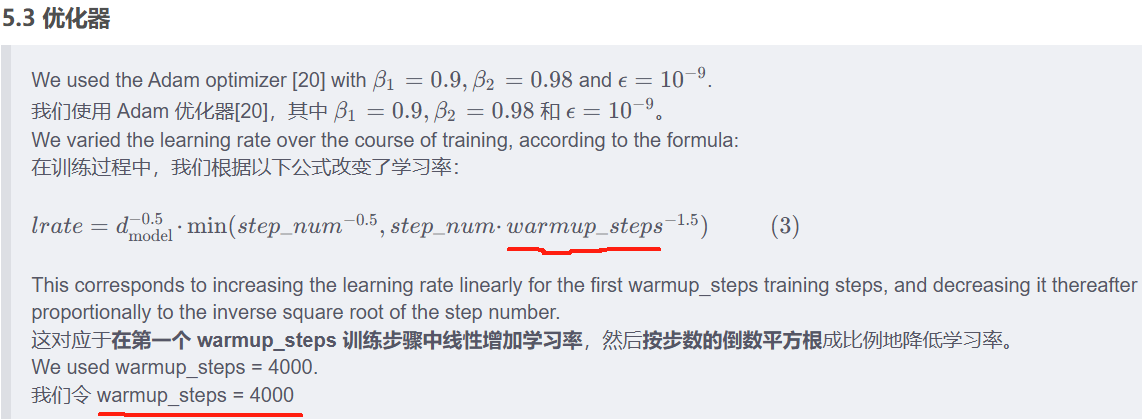

In [ ]:
def rate(step, model_size, factor, warmup):
  """
  we have to default the step to 1 for LambdaLR function
  to avoid zero raising to negative power.
  """
  if step == 0:
      step = 1
  return factor * (
      model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
  )

In [ ]:
!wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

--2025-04-08 08:15:02--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  6.64MB/s    in 1.4s    

2025-04-08 08:15:05 (6.64 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



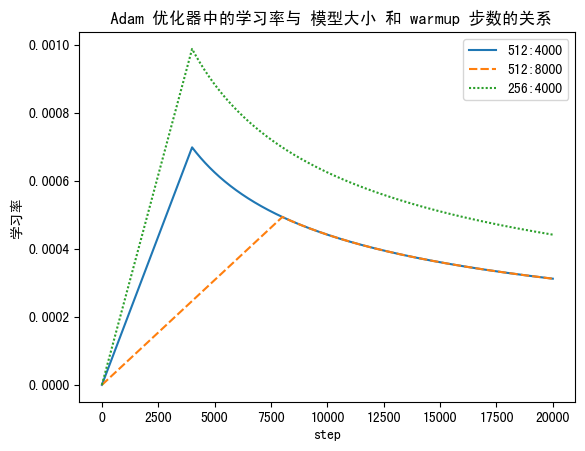

In [ ]:
# colab notebook 显示中文
# 第一步： !wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

# 第二步：新增字体
import matplotlib
matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')
import warnings
warnings.filterwarnings("ignore")


def example_learning_schedule():
  opts = [
    [512, 1, 4000],  # example 1
    [512, 1, 8000],  # example 2
    [256, 1, 4000],  # example 3
  ]

  dummy_model = torch.nn.Linear(1, 1)
  learning_rates = []

  # we have 3 examples in opts list.
  for idx, example in enumerate(opts):
    # run 20000 epoch for each example
    optimizer = torch.optim.Adam(
      dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
      optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
    )
    tmp = []
    # take 20K dummy training steps, save the learning rate at each step
    for step in range(20000):
      tmp.append(optimizer.param_groups[0]["lr"])
      optimizer.step()
      lr_scheduler.step()
    learning_rates.append(tmp)

  learning_rates = torch.tensor(learning_rates)

  # Enable altair to handle more than 5000 rows
  # alt.data_transformers.disable_max_rows()

  # print(learning_rates)

  df = pd.DataFrame(
    {
      "512:4000": learning_rates[0],
      "512:8000": learning_rates[1],
      "256:4000": learning_rates[2],
    }
   )
  # 绘图比较
  # palette={'DQN':'gray','DDQN':'blue','Dueling DQN':'red'},style_order=['Dueling DQN','DDQN','DQN']
  sns.lineplot(data=df, linewidth=1.5).set(
      title=" Adam 优化器中的学习率与 模型大小 和 warmup 步数的关系"  )
  # 显示图例
  # plt.legend(title='model_size:warmup_steps')
  # 设置横轴标签
  plt.xlabel('step')
  # 设置纵轴标签
  plt.ylabel('学习率')

example_learning_schedule()

## 5.4 正则化

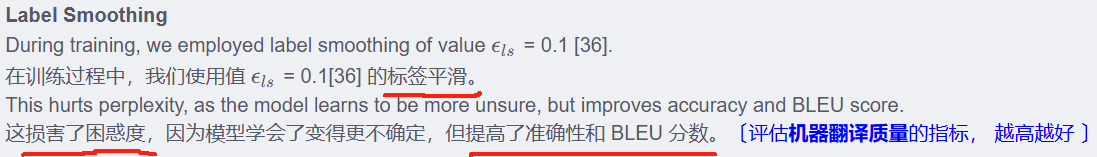

In [ ]:
class LabelSmoothing(nn.Module):
  "实现 标签平滑"

  def __init__(self, size, padding_idx, smoothing=0.0):
    super().__init__()
    self.criterion = nn.KLDivLoss(reduction="sum")
    self.padding_idx = padding_idx
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.size = size
    self.true_dist = None

  def forward(self, x, target):
    assert x.size(1) == self.size
    true_dist = x.data.clone()
    true_dist.fill_(self.smoothing / (self.size - 2))
    true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
    true_dist[:, self.padding_idx] = 0
    mask = torch.nonzero(target.data == self.padding_idx)
    if mask.dim() > 0:
      true_dist.index_fill_(0, mask.squeeze(), 0.0)
    self.true_dist = true_dist
    return self.criterion(x, true_dist.clone().detach())

### 使用示例：

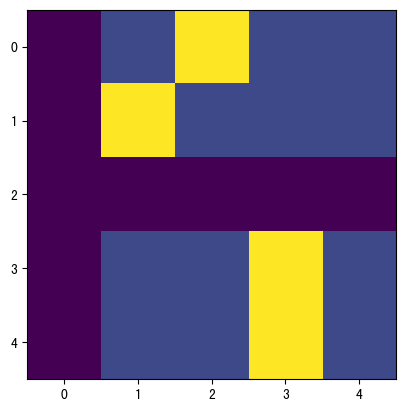

In [ ]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                [0, 0.2, 0.7, 0.1, 0],
                [0, 0.2, 0.7, 0.1, 0],
                [0, 0.2, 0.7, 0.1, 0],
                [0, 0.2, 0.7, 0.1, 0],])
v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0, 3, 3])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

补充：

标签平滑是一种正则化技术，用来防止模型在训练过程中对训练标签过于自信，从而**减少过拟合**。通常，在分类问题中，标签会用 one-hot 编码，比如类别是 3 类的话，正确的类别会是 [1,0,0]，其它是 0。但这样可能**导致模型过度自信，泛化能力下降**。标签平滑就是将这些**硬标签变成软标签**，比如正确的类别变成 0.9，剩下的两个类别各分配 0.05，这样总和还是 1。

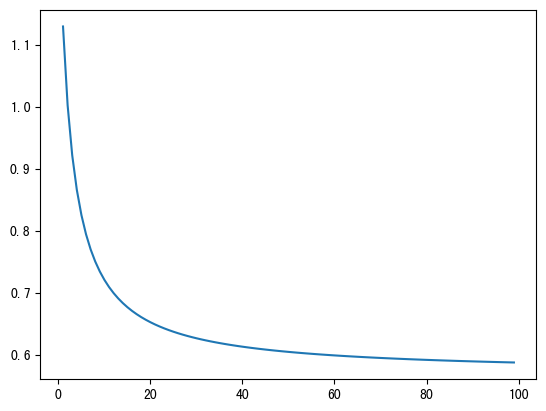

In [ ]:
# 标签平滑： 让其它标签具有较小概率的可能性

crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
  d = x + 3 * 1
  predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
  # print(predict)
  return crit(torch.log_softmax(predict, dim=1),
         Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

<font color=red><font size=4>不太理解这里。

# —— 示例 1： 复制任务

给定一个小词汇表中的随机输入符号集，目标是**生成这些相同的符号**。

In [ ]:
# 合成数据

def data_gen(V, batch_size, nbatches):
  "Generate random data for a src-tgt copy task."
  for i in range(nbatches):
    data = torch.randint(1, V, size=(batch_size, 10))
    data[:, 0] = 1
    src = data.requires_grad_(False).clone().detach()
    tgt = data.requires_grad_(False).clone().detach()
    yield Batch(src, tgt, 0)

# 计算损失
class SimpleLossCompute:
  "A simple loss compute and train function."

  def __init__(self, generator, criterion):
    self.generator = generator
    self.criterion = criterion

  def __call__(self, x, y, norm):
    x = self.generator(x)
    sloss = (
        self.criterion(
            x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
        )
        / norm
    )
    return sloss.data * norm, sloss

######  训练简单的复制任务。
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
# model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
#         torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

optimizer = torch.optim.Adam(
    model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
)
lr_scheduler = LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: rate(
        step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
    ),
)
batch_size = 80
for epoch in range(10):
  model.train()
  run_epoch(
    data_gen(V, batch_size, 20),
    model,
    SimpleLossCompute(model.generator, criterion),
    optimizer,
    lr_scheduler,
    mode="train",
  )
  model.eval()


Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.95 | Tokens / Sec:   467.9 | Learning Rate: 5.5e-06
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.04 | Tokens / Sec:   542.5 | Learning Rate: 6.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.75 | Tokens / Sec:   430.4 | Learning Rate: 1.2e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.50 | Tokens / Sec:   546.8 | Learning Rate: 1.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.06 | Tokens / Sec:   547.2 | Learning Rate: 2.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.67 | Tokens / Sec:   542.4 | Learning Rate: 2.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.43 | Tokens / Sec:   372.1 | Learning Rate: 3.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.26 | Tokens / Sec:   548.2 | Learning Rate: 3.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.17 | Tokens / Sec:   543.3 | Learning Rate: 4.5e-04
Epoch Step:      1 | Accumul

In [ ]:
# 使用贪婪解码 预测 翻译。
def greedy_decode(model, src, src_mask, max_len, start_symbol):
  memory = model.encode(src, src_mask)
  ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
  for i in range(max_len - 1):
    out = model.decode(
      memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
    )
    prob = model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat(
      [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
    )
  return ys

##### 推理
model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

# —— 真实世界 示例

现在我们考虑一个使用 IWSLT 德语-英语翻译任务的真实示例。这个任务比本文中考虑的 WMT 任务小得多，但它说明了整个系统。我们还展示了如何使用多 GPU 处理使其非常快。

还有一些**可视化自注意**的内容，用到再整理。